# Facial Keypoint Detection


## Initialize environment

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Convolution2D, BatchNormalization, Flatten
from tensorflow.keras.layers import Dense, Dropout, Input, MaxPool2D
from tensorflow.keras.optimizers import Nadam
from keras import backend
import os, gc, json, math

In [3]:
import keras
print(keras.__version__)
import tensorflow
print(tensorflow.__version__)

2.2.4
1.13.1


In [8]:

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del model # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tensorflow.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.Session(config=config))
    
reset_keras()    

23


In [9]:
if not os.path.exists('../output/'):
    os.makedirs('../output/model')
    os.makedirs('../output/history')
    
    
model_dir = "../output/model/"
history_dir = "../output/history/"

train_file = '../input/training/training.csv'
test_file = '../input/test/test.csv'
train_data = pd.read_csv(train_file)  
test_data = pd.read_csv(test_file)

## Exploratory Data Analysis

In [10]:
train_data.head().T

,0,1,2,3,4
left_eye_center_x,66.0336,64.3329,65.0571,65.2257,66.7253
left_eye_center_y,39.0023,34.9701,34.9096,37.2618,39.6213
right_eye_center_x,30.227,29.9493,30.9038,32.0231,32.2448
right_eye_center_y,36.4217,33.4487,34.9096,37.2618,38.042
left_eye_inner_corner_x,59.5821,58.8562,59.412,60.0033,58.5659
left_eye_inner_corner_y,39.6474,35.2743,36.321,39.1272,39.6213
left_eye_outer_corner_x,73.1303,70.7227,70.9844,72.3147,72.5159
left_eye_outer_corner_y,39.97,36.1872,36.321,38.381,39.8845
right_eye_inner_corner_x,36.3566,36.0347,37.6781,37.6186,36.9824
right_eye_inner_corner_y,37.3894,34.3615,36.321,38.7541,39.0949


Check missing values and replace NaN's with mean values in that column

In [11]:
train_data.isnull().any().value_counts()
columns_nan = train_data.columns[train_data.isna().any()].tolist()
train_data[columns_nan] = train_data[columns_nan].fillna(value=train_data[columns_nan].mean())

Create training vector with images and normalize thee

In [12]:

x_train = []
for i in range(train_data.shape[0]):
    image = train_data['Image'][i].split(' ')
    image = ['0' if x == '' else x for x in image]
    x_train.append(image)
    
x_train = np.array(x_train,dtype = 'float')
x_train = x_train/255.0
x_train = x_train.reshape(-1,96,96,1)
    

Display test image.

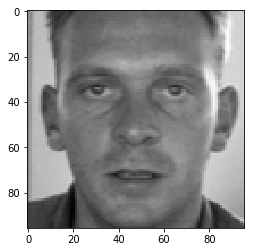

In [13]:
plt.imshow(x_train[2].reshape(96,96),cmap='gray')
plt.show()

Generate labels 

In [14]:

y_train = []
for i in range(train_data.shape[0]):
    label = train_data.iloc[i,0:30]
    y_train.append(label)
    
y_train = np.array(y_train,dtype = 'float')



In [35]:
# Define callback function if detailed log required
class History(tensorflow.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.train_loss = []
        self.train_rmse = []
        self.val_rmse = []
        self.val_loss = []

    def on_batch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.train_rmse.append(logs.get('rmse'))
        
    def on_epoch_end(self, batch, logs={}):    
        self.val_rmse.append(logs.get('val_rmse'))
        self.val_loss.append(logs.get('val_loss'))
        
# Implement ModelCheckPoint callback function to save CNN model
class CNN_ModelCheckpoint(tensorflow.keras.callbacks.Callback):

    def __init__(self, model, filename):
        self.filename = filename
        self.cnn_model = model

    def on_train_begin(self, logs={}):
        self.max_val_rmse = math.inf
        
 
    def on_epoch_end(self, batch, logs={}):    
        val_rmse = logs.get('val_rmse')
        if(val_rmse < self.max_val_rmse):
           self.max_val_rmse = val_rmse
           self.cnn_model.save(self.filename)


In [44]:
def base_model():
    model_input = Input(shape=(96,96,1))

    x = Convolution2D(32, (3,3), padding='same', use_bias=False)(model_input)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Convolution2D(64, (3,3), padding='same', use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Convolution2D(96, (3,3), padding='same', use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Convolution2D(128, (3,3),padding='same', use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Convolution2D(256, (3,3),padding='same',use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Convolution2D(512, (3,3), padding='same', use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(512,activation='relu')(x)
    x = Dropout(0.2)(x)
    model_output = Dense(30)(x)
    model = Model(model_input, model_output, name="base_model")
    return model

model = base_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18432     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 48, 48, 64)        0         
__________

In [45]:
# Custom RMSE metric
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

#from tensorflow.keras.optimizers.schedules import InverseTimeDecay

# Use Nadam optimizer with variable learning rate
optimizer = Nadam(lr=0.00001,
                  beta_1=0.9,
                  beta_2=0.999,
                  epsilon=1e-08,
                  schedule_decay=0.004)


# Loss: MSE and Metric = RMSE
model.compile(optimizer= optimizer, 
              loss='mean_squared_error',
              metrics=[rmse])

#Callback to save the best model
saveBase_Model = CNN_ModelCheckpoint(model, model_dir+"base_model.h5")

#define callback functions
callbacks = [#EarlyStopping(monitor='val_rmse', patience=3, verbose=2),
             saveBase_Model]

Run for 1000 epochs and keeping 20% train-valid split

In [36]:
history = model.fit(x_train,
                    y_train,
                    epochs = 1000,
                    batch_size = 256,
                    validation_split = 0.2,
                    callbacks = callbacks
                    )

Train on 5639 samples, validate on 1410 samples
Epoch 1/1000
5639/5639 [==============================] - 112s 20ms/sample - loss: 2535.5595 - rmse: 50.3386 - val_loss: 2642.1320 - val_rmse: 51.3976
Epoch 2/1000
5639/5639 [==============================] - 112s 20ms/sample - loss: 2308.5175 - rmse: 48.0227 - val_loss: 2645.1962 - val_rmse: 51.4274
Epoch 3/1000
 256/5639 [>.............................] - ETA: 1:37 - loss: 2152.0903 - rmse: 46.3641

KeyboardInterrupt: 

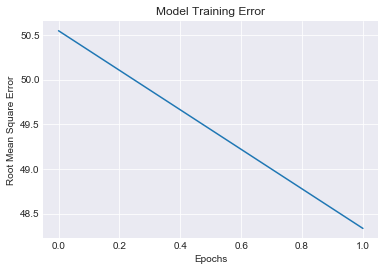

2218


In [40]:
plt.style.use('seaborn-darkgrid')
plt.plot(history.history['rmse'])
plt.xlabel('Epochs')
plt.ylabel('Root Mean Square Error')
plt.title('Model Training Error')
plt.show()
reset_keras() 

In [42]:
del model

In [46]:
sess = get_session()
clear_session()
sess.close()
sess = get_session()
try:
    del model # this is from global space - change this as you need
except:
    print("Model clear Failed")

In [48]:
model

NameError: name 'model' is not defined